

## <font color="purple"> Problem </font>
The Stanford Sentiment Treebank1 data set (SST-2) consists of ~68,000 sentences
from movie reviews and annotations of their sentiment – 0 for negative reviews, 1 for
positive reviews.

SST-2 is one of GLUE benchmark tasks for natural language processing systems.Two files are of
interest, train.tsv and dev.tsv, containing annotated reviews to be used for training
and testing, respectively.

## <font color="purple"> Question 1 </font>
### <font color="blue"> Exploratory Data Analysis </font>
Explore the distribution of positive and negative
reviews in the SST-2 dataset, identify any data imbalances, and discuss potential
implications for model training and evaluation. Apply appropriate visualisation of
the data sets where necessary. 

To explore the distribution of positive and negative reviews, I first import all the packages I will be using, then I load all the necessary data files: `train.tsv`, `test.tsv` and `dev.tsv`. For questions 1-5, I will be focusing on `train.tsv`. I load the files with the pandas `.read_csv()` function and convert the `review_train` one to a dataframe to make it easier to work with. I decided to plot a histogram and a box plot to visualize the data distribution as we are dealing solely with binary values `0` and `1`.

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split as split
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

#font
plt.rc('font', **{'family':'sans-serif', 'sans-serif':['Arial'], 'size' : 20})


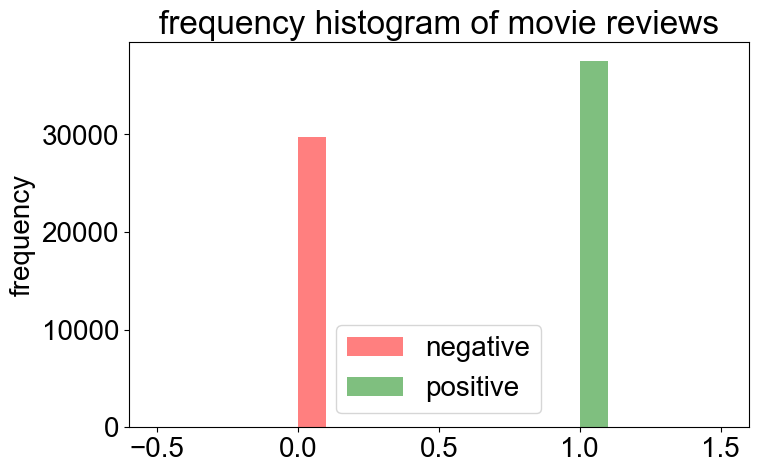

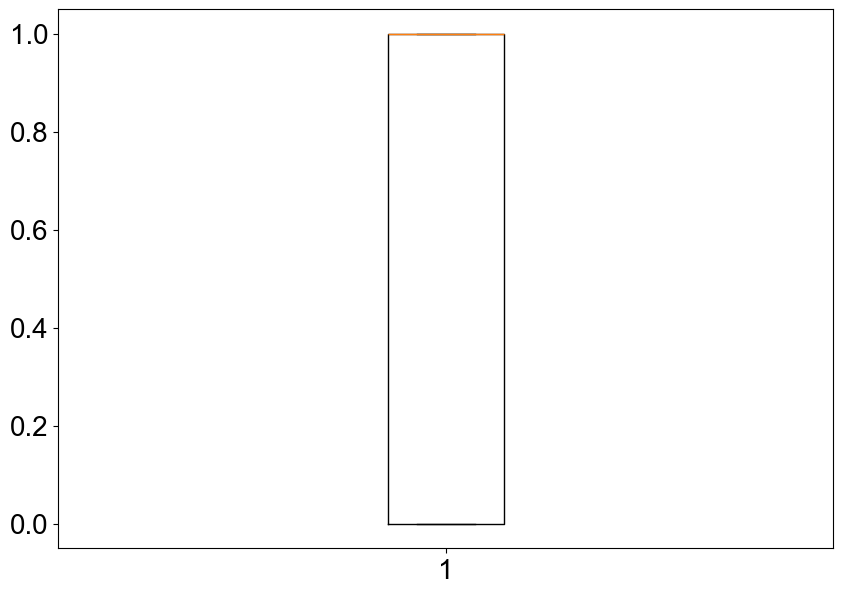

In [2]:
#instance of count vecorizer and converting and the data to lowercase
vectorizer = CountVectorizer(lowercase=True)
#reading all the necessary data files
reviews_train = pd.read_csv("./train.tsv", sep='\t', encoding='utf-8', skiprows=1, header=None)
reviews_test = pd.read_csv("./test.tsv", sep='\t')
reviews_eval = pd.read_csv("./dev.tsv", sep='\t')

#debugging
#print(reviews_train)

df = pd.DataFrame(reviews_train)
df["reviews"] = reviews_train[0].values
df["ratings"] = reviews_train[1].values
#print(df)

negative_reviews = df[df.ratings==0].ratings
positive_reviews = df[df.ratings==1].ratings

#frequency histogram [1]
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':100})
kwargs = dict(alpha=0.5, bins=10)
plt.hist(negative_reviews, **kwargs, color='r', label='negative')
plt.hist(positive_reviews, **kwargs, color='g', label='positive')
plt.gca().set(title='frequency histogram of movie reviews', ylabel='frequency')
plt.legend();

#box-plot [2]
fig = plt.figure(figsize =(10, 7)) 
plt.boxplot(df["ratings"])
plt.show()


A box plot is a chart that shows data from a five-number summary including one of the measures of central tendency. The five-number summary in the box plot is `minimum`, `maximum`, `median`, `first quartile`, and `third quartile`. The box plot is said to be symmetric if the median is equidistant from the minimum and maximum value. It is primarily used to indicate if a distribution is skewed or not and if there are potential unusual observations (also called outliers) present in the data set. Boxplots are also very beneficial when large numbers of data sets are involved or compared. For a distribution that is negatively skewed, the box plot will show the median closer to the upper or top quartile <sup>[1]</sup>. That is the case with our training data, the median is right at the top quartile making our data negatively skewed. A distribution is considered **Negatively Skewed** when **mean < median**. This finding is supported by the histogram where the frequency of `1` is way more than the frequency of `0` which would lend to the skewing of our data. 

A histogram is a plot of the frequency distribution of numeric array by splitting it to small equal-sized bins. A histogram is drawn on large arrays. It computes the frequency distribution on an array and makes a histogram out of it <sup>[2]</sup>. The histogram above is certainly more helpful in visualizing our data as we are able to more clearly see the frequency of positive vs negative reviews and determine that the data is skewed towards the positive reviews.

Bar charts were also considered here, but they are better used when you have both X and Y given and there are limited number of data points that can be shown as bars. There are over **68,000** lines of data in our dataset with only `0` and `1` values so this wouldn't have been so helpful.

## <font color="purple"> Question 2 </font>
### <font color="blue"> The Text Vectorisation Method of choice. </font>
Compare and contrast the efficiency
of at least two vector representations of movie reviews in the data set. Choose
the most appropriate method based on its effectiveness in capturing the
sentiment information. Consider providing explanations or justifications for your
choices 

To compare two vectorizers, I will be using the `Tf-Idf Vectorizer` and the `CountVectorizer` (both with stop words removed). I will be performing an *Ablation Study* to measure the effciency of the two. Ablation Studies are very important to provide ways to measure the contribution of  parts to the overall model. In this case the parts being measured are the vectorizers. To make the comparison I will be training the `Naive Bayes` (`MultinomialNB` instead of `GaussianNB` because words are discrete not continuous distribution) model. The `CountVectorizer` converts a collection of strings to a of token counts, while the `Tf-Idf Vectorizer` is a bit more involved. Term frequency–inverse document frequency, aka. tf-idf, is a score that measures how important a word is to a text corpus. The vectorizer  converts a collection of raw documents to a matrix of TF-IDF features. **TF-IDF** enables us to weight words based on how important they are to a string. On one hand, high TF-IDF score (or weight) is given to words, or terms, that appear often in a particular string, but don't appear often in the corpus (across all strings). On the other hand, features with low TF-IDF weight are either commonly used across all strings or rarely used and only occur in long strings <sup>[4]</sup>. 

In [3]:
reviews_train_original = pd.read_csv("./train.tsv", sep='\t', encoding='utf-8', skiprows=0)
class Dataset(object):
    """
    A helper data structure to store the input reviews (X) and labels (y) of our dataset.
    """
    def __init__(self):
        self.X = None
        self.y = None
        # Vectorized input text features
        self.V = None


X = reviews_train_original["sentence"]
y = reviews_train_original["label"]

train = Dataset()
test = Dataset()

train.X, test.X, train.y, test.y = split(X, 
                                         y,
                                         test_size=0.25,
                                         random_state=123456789)

vectorizers = {
    'TF-IDF w/stop words removed':                            TfidfVectorizer(stop_words='english'),
    'Count Vectorizer w/stop words removed':               CountVectorizer(stop_words='english')
}

for description, vectorizer in vectorizers.items():

    # Create the vocabulary based on the training data
    vectorizer.fit(train.X)
    
    # Encode the words in the training and test dataset based on the vocabulary
    train.V = vectorizer.transform(train.X)
    test.V = vectorizer.transform(test.X)    
    # Train the classifier
    model = MultinomialNB(alpha=0.5).fit(X=train.V, y=train.y)

    print(f'\n{description}\n')
    
    print("- Number of features: {:6d}".format(len(vectorizer.get_feature_names_out())))

    print("- Training accuracy:  {:.2%}".format(model.score(train.V, train.y)))
    print("- Test accuracy:      {:.2%}".format(model.score(test.V, test.y)))


TF-IDF w/stop words removed

- Number of features:  13329
- Training accuracy:  90.41%
- Test accuracy:      87.49%

Count Vectorizer w/stop words removed

- Number of features:  13329
- Training accuracy:  89.25%
- Test accuracy:      86.85%


In the code above the `Dataset` objects helps split our data set into random train and test subsets. By default, $75\%$ of the data are reserved for training and the rest for testing. I use a `for loop` to loop through my `vectorizers` object and then create my vocabulary by fitting each vectorizer (`Tf-Idf` and `CountVectorizer`) to the training data. Then I encode the words in both the train and test `Datasets` based on the vocabulary created using `.fit()`. I then train my `MultinomialNB` classifier with the vectorized data and the `ratings` in the training data. The results prove that the **TF-IDF w/stop words removed** method is a **more accurate** Text Vectorization method with a **90.41** percent training accuracy and **87.49** percent test accuracy, while the `CountVectorizer` has a **89.25** percent training accuracy and **86.85** percent test accuracy. The ability to weight words with `Tf-Idf` definitely lends to the model prediction accuracy versus `CountVectorizer` which only returns the frequency of each unique words.

## <font color="purple"> Question 3 </font>
### <font color="blue"> The Machine Learning Model of Choice </font>
Compare and contrast the efficiency of
at least two models for classification we have studied in class. Evaluate their
performance in terms of accuracy, precision, recall, and F1-score. Discuss the
strengths and weaknesses of each model and select the one that achieves the
highest accuracy

For this question, I will be comparing the `MultinomialNB` and `k-Nearest-Neighbours (kNN)` classifiers. The `MultinomialNB` classifier is the `Naive Bayes` classifier for multinomial models. As noted in question 2, it is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work <sup>[5]</sup>. 

`k-Nearest Neighbours` algorithm, aka kNN or k-NN is a non-parametric, supervised learning classifier. kNN can be used for either regression or classification problems but it is commonly used as a classification algorithm based on the assumption that similar points can be found near one another. For classification problems, a class label is assigned on the basis of a majority vote i.e. the label that is most frequently represented around a given data point is used. However, as a dataset grows, KNN becomes increasingly inefficient, compromising overall model performance. <sup>[6]</sup>. It is difficult to know in advance which machine learning model(s) will perform best for a given dataset. This is particularly true when using a Python library like `sklearn`, where the implementation details are hidden from us. To make this comparison a bit easier we can use `cross_validation`. The main idea is to use all data for training and testing by splitting the data set into K equally-sized folds (i.e., data partitions). Suppose that $K=4$, resulting in 4 folds, $S_1, S_2, S_3$ and $S_4$.
Then, for each type of model (or parameter value for a given model) we perform $K$  runs:

1. Train the model with $S_2, S_3, S_4$ and test with $S_1$

2. Train the model with $S_1, S_3, S_4$ and test with $S_2$

3. Train the model with $S_1, S_2, S_4$ and test with $S_3$

4. Train the model with $S_1, S_2, S_3$ and test with $S_4$

Then, we average the classification scores from each run. The `KFold` object can be used in conjunction with the `cross_val_score` function to perform a K-fold cross-validation in Python. In the code below I am using `n_splits=`$10$ to specify 10 _number of folds_, $K$. <sup>[6]</sup>



In [4]:
#settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

#fitting KNN model as MultinomialNB has already been fitted in q2


estimators = {
    'K-nearest neighbours': KNeighborsClassifier(),
    'Multinomial Naive Bayes': MultinomialNB()
}

folds = KFold(n_splits=10, random_state=123456789, shuffle=True) #shuffle=True randomises the data before splitting it into folds

for name, classifier in estimators.items():    
    # Train the classifier
    classifier.fit(X=train.V, y=train.y)
    #cross-validate classifier
    scores = cross_val_score(estimator=classifier, X=train.V, y=train.y, cv=folds)
    #report
    predictions = classifier.predict(test.V)
    report = classification_report(test.y, predictions)
    print(f'{name:20s}: {scores.mean():.2%} +- {scores.std():.2%}')
    test_accuracy = classifier.score(test.V, test.y)
    test_accuracy = test_accuracy * 100.0
    print('Test accuracy is {:5.2f}%'.format(test_accuracy))
    train_accuracy = classifier.score(train.V, train.y)
    train_accuracy = train_accuracy * 100.0
    print('Train accuracy is {:5.2f}%'.format(train_accuracy))
    print(report)

#this shell might take a bit long to run, but it works.

K-nearest neighbours: 83.36% +- 0.53%
Test accuracy is 84.32%
Train accuracy is 90.39%
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      7509
           1       0.85      0.87      0.86      9329

    accuracy                           0.84     16838
   macro avg       0.84      0.84      0.84     16838
weighted avg       0.84      0.84      0.84     16838

Multinomial Naive Bayes: 86.50% +- 0.57%
Test accuracy is 86.51%
Train accuracy is 88.99%
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      7509
           1       0.87      0.89      0.88      9329

    accuracy                           0.87     16838
   macro avg       0.86      0.86      0.86     16838
weighted avg       0.86      0.87      0.86     16838



In the code above, I am building a text report of the main classification metrics to compare the two models:

- `Precision` measures the fraction of correct predictions versus total predictions (incl. errors) for a particular label.

- `Recall` measures the ability of a classifier to classify correctly all instances of a particular label.

- `F-1 score` is a weighted harmonic mean of the precision and recall (0 (worst) to 1 (best)).

- `Support` is the number of instances of each label.

The `Multinomial Naive Bayes` model achieves the highest accuracy with **86.51%** test accuracy, while the `K-Nearest neighbours` achieves and **84.32%**. It also has a higher `precision` , `recall` and `f1-score` for both `0` and `1` values. Interestingly enough, the `KNN` model has a higher training accuracy with **90.39%**, compared to **88.99%** of `MultinomialNB`. Based on this outcome, the `Multinomial Naive Bayes` model will be chosen for *hyper-parameter* tuning in the next question.

## <font color="purple"> Question 4 </font>
### <font color="blue"> The Hyper-Parameter Values of Choice </font>
Explore at least two hyper-parameters
for a given model. Explain the rationale behind the selection of the explored
hyperparameters by performing a systematic search and evaluation of different
hyperparameter values to optimise the model's performance. Report the best
hyperparameter values that result in the highest accuracy. 

In practical machine learning applications, we need to set a number of `hyper-parameters`. Besides tuning a particular model, we also want to consider a range of different types of model to find the best one for a particular application. Each model has a number of hyper-parameters that can be tuned for a particular application and data set. It is difficult to find the values of the important parameters of a model that provide the best generalisation performance.
Hyperparameter tuning is essentially automated hyperparameter optimization and some of it's advantages include:
- Reduces human effort.
- Less prone to error.
- Data-driven approaches may be effective <sup>[7]</sup>.

**`Grid search`** is a method to try all possible combinations of the parameters of interest and evaluating the model for each combination. The combination that gives the best performance is then selected. Similar to the method used for model comparison in the previous question, it uses `K-fold cross-validation` behind the scenes for finding the best combination.

In [5]:
hyper_params = {
    'Multinomial Naive Bayes': MultinomialNB()
}

for name2, classifier2 in hyper_params.items():
    print(f'{name2} hyper-parameters\n')
    params = classifier2.get_params()
    for param, default in params.items():
        print(f'... {param:25s}: {default}')
    print()

Multinomial Naive Bayes hyper-parameters

... alpha                    : 1.0
... class_prior              : None
... fit_prior                : True
... force_alpha              : warn



The code above lists all the hyper-parameters of the `Multinomial Naive Bayes` classifier: `alpha`, `class_prior`, `fit_prior`, and `force_alpha`. I will be exploring the `alpha` hyper-paramater with `GridSearchCV`. The code below reveals that the best hyper-parameter is `alpha: 0.1` and the tuned model has a best training accuracy of **86.54%** and a test accuracy of **86.93%**. The *hyper-parameter tuned* `MultinomialNB` classifier does not have a significantly higher test or training accuracy, maintaining steady results as the untuned classifier used in the previous question. Hyper-parameter tuning is **not always necessary** though as in some cases they may interact with each other in unexpected ways and can take a long time to execute. It's also difficult to know exactly how to choose them, there is no single function/formula to apply.

In [6]:
from sklearn.model_selection import GridSearchCV
#the grid search will be performed over the hyperparameter alpha of the Multinomial Naive Bayes classifier [8]
parameters = {'alpha': [0.01, 0.1, 1, 10]}
nb = MultinomialNB()
gs = GridSearchCV(nb, parameters)

gs.fit(X=train.V, y=train.y);

print("Best hyperparameter:", gs.best_params_)
print(f'Best training accuracy is {gs.best_score_:.2%}')
#Report performance of best parameter settings on test set
print(f'Test accuracy is {gs.score(test.V, test.y):.2%}')

Best hyperparameter: {'alpha': 0.1}
Best training accuracy is 86.54%
Test accuracy is 86.93%


## <font color="purple"> Question 5 </font>
### <font color="blue"> Model Deployment </font>
Deploy the model that achieved the best accuracy to a
production environment so that it can be used to predict the sentiment of reviews in real time. Apply visualisation of the model’s results where appropriate.

In [17]:
best_vectorizer = TfidfVectorizer(stop_words='english').fit(train.X)
best_model = MultinomialNB(alpha=0.1).fit(X=train.V, y=train.y)


def predict(comment, vectorizer, model):
    """
    Predicts the sentiment of the test.tsv comments with our best vectorizer and model.
    """
    features = best_vectorizer.transform(comment)
    return(best_model.predict(features))



model_results = predict(reviews_test["sentence"], best_vectorizer, best_model) 
pd.set_option('display.max_colwidth', None)
reviews_test["ratings"] = model_results
styled_df = reviews_test.style.hide()
styled_df



index,sentence,ratings
0,uneasy mishmash of styles and genres .,0
1,this film 's relationship to actual tension is the same as what christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation .,0
2,"by the end of no such thing the audience , like beatrice , has a watchful affection for the monster .",1
3,director rob marshall went out gunning to make a great one .,1
4,"lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new .",1
5,a well-made and often lovely depiction of the mysteries of friendship .,1
6,"none of this violates the letter of behan 's book , but missing is its spirit , its ribald , full-throated humor .",0
7,"although it bangs a very cliched drum at times , this crowd-pleaser 's fresh dialogue , energetic music , and good-natured spunk are often infectious .",1
8,it is not a mass-market entertainment but an uncompromising attempt by one artist to think about another .,0
9,this is junk food cinema at its greasiest .,0


The code above makes use of the Text Vectorization method of choice from question 2 (`TfIdfVectorizer` with stop words removed) + the Machine Learning Model of Choice (`Multinomial Naive Bayes` Classifier, with the `alpha` hyper-parameter tuned to **0.1** and uses a defined `predict` function to test the unlabelled test data found in `test.tsv` and stored in the `reviews_test` DataFrame. The function takes in every comment, transforms it with the `TfIdfVectorizer` and uses the `MultinomialNB` model trained on the `train.tsv` data to predict whether each comment is a `0` (*negative*) or `1` (*positive*). The results of the function are then stored as a list in `model_results` and this is added as a column `ratings` to the `reviews_test` DataFrame. The DataFrame is printed out above and upon visual analysis it is clear that the model accurately predicts majority of the reviews, though not perfectly as there are a few ambiguous ratings that are wrongly labelled. For example indexes **1679**: `as a revenge thriller , the movie is serviceable , but it doesn't really deliver the delicious guilty pleasure of the better film versions.` and **1680**: `frustratingly , dridi tells us nothing about el gallo other than what emerges through his music.` are both given ratings of `1`, but they aren't necessarily positive reviews. Again, the model did not acheive **100%** accuracy so this is understandable.

## <font color="purple"> Question 6 </font>
In the end, your report should position your best result with respect to the
leader-board for SST-2, available at <a href="https://gluebenchmark.com/leaderboard"> GlueBench </a>. 
Compare your achieved accuracy with the top-performing models and discuss the reasons
for any differences and identify potential areas for further improvement. 

My best test accuracy after hyper-parameter tuning is **86.93%** putting me at about **Number 24** on the SST-2 leader-board. The person right below me has a score of **85.6%** and they used an `ELECTRA` model. ELECTRA is a method for self-supervised language representation learning. It can be used to pre-train transformer networks using relatively little compute. ELECTRA models are trained to distinguish "real" input tokens vs "fake" input tokens generated by another neural network, similar to the discriminator of a GAN (*Generative Adversarial Net*)<sup>[9]</sup>. Looking through that submission and some of the others, they definitely did more complex machine learning than I did with the scope of this assignment. I'm sure with a deeper understanding of this subject, I might have chose a different model or made different decisions about the Text Vectorization Method of choice, etc, which would have had an impact on my accuracy scores.

## <font color="purple"> References</font>
- [1] “Box Plot (Definition, Parts, Distribution, Applications & Examples),” BYJUS. https://byjus.com/maths/box-plot/
- [2] S. Prabhakaran, “Matplotlib Histogram - How to Visualize Distributions in Python - ML+,” Machine Learning Plus, Feb. 23, 2019. https://www.machinelearningplus.com/plots/matplotlib-histogram-python-examples/
- [3] P. Antoniadis, “Machine Learning: What Is Ablation Study? | Baeldung on Computer Science,” www.baeldung.com, Jun. 18, 2022. https://www.baeldung.com/cs/ml-ablation-study
- [4] Week 10: Text Analytics Lab
- [5] “sklearn.naive_bayes.MultinomialNB — scikit-learn 0.22 documentation,” Scikit-learn.org, 2019. https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
- [6] Week 9: Machine Learning Applications Lab
- [7] “6. Naive Bayes and Hyperparameter Optimization — BAIT 509Business Applications of Machine Learning,” bait509-ubc.github.io. https://bait509-ubc.github.io/BAIT509/lectures/lecture6.html# (accessed Nov. 30, 2023).
- [8] “Hyper parameter tuning techniques for Naiv,” kaggle.com. https://www.kaggle.com/code/pavanchauhan8702/hyper-parameter-tuning-techniques-for-naiv (accessed Nov. 30, 2023).
- [9]“google-research/electra,” GitHub, May 12, 2021. https://github.com/google-research/electra
‌